# PPO for Portfolio Management
This tutorial is to demonstrate an example of using PPO to do portfolio management

## Step1: Import Packages

In [1]:

import warnings
warnings.filterwarnings("ignore")
import sys
from pathlib import Path
import os
import torch

ROOT = os.path.dirname(os.path.abspath("."))
sys.path.append(ROOT)

import argparse
import os.path as osp
from mmcv import Config
from trademaster.utils import replace_cfg_vals
from trademaster.nets.builder import build_net
from trademaster.environments.builder import build_environment
from trademaster.datasets.builder import build_dataset
from trademaster.agents.builder import build_agent
from trademaster.optimizers.builder import build_optimizer
from trademaster.losses.builder import build_loss
from trademaster.trainers.builder import build_trainer
from trademaster.utils import plot
from trademaster.utils import set_seed
set_seed(2023)

2023-05-12 00:34:24,283	INFO worker.py:973 -- Calling ray.init() again after it has already been called.


## Step2: Import Configs

In [2]:
parser = argparse.ArgumentParser(description='Download Alpaca Datasets')
# parser.add_argument("--config", default=osp.join(ROOT, "configs", "portfolio_management", "portfolio_management_sse500_sarl_sarl_adam_mse.py"),
# parser.add_argument("--config", default=osp.join(ROOT, "configs", "portfolio_management", "portfolio_management_exchange_ppo_ppo_adam_mse.py"),
# parser.add_argument("--config", default=osp.join(ROOT, "configs", "portfolio_management", "portfolio_management_sz50_ppo_ppo_adam_mse.py"),
parser.add_argument("--config", default=osp.join(ROOT, "configs", "portfolio_management", "portfolio_management_sz50_sarl_sarl_adam_mse.py"),
                    help="download datasets config file path")
parser.add_argument("--task_name", type=str, default="train")
args, _ = parser.parse_known_args()

cfg = Config.fromfile(args.config)
task_name = args.task_name
cfg = replace_cfg_vals(cfg)
print(cfg)

Config (path: /Users/louison/PersonalTrade/configs/portfolio_management/portfolio_management_sz50_sarl_sarl_adam_mse.py): {'data': {'type': 'PortfolioManagementDataset', 'data_path': 'data/portfolio_management/sz50', 'train_path': 'data/portfolio_management/sz50/train.csv', 'valid_path': 'data/portfolio_management/sz50/valid.csv', 'test_path': 'data/portfolio_management/sz50/test.csv', 'tech_indicator_list': ['zopen', 'zhigh', 'zlow', 'zadjcp', 'zclose', 'zd_5', 'zd_10', 'zd_15', 'zd_20', 'zd_25', 'zd_30'], 'length_day': 10, 'initial_amount': 100000, 'transaction_cost_pct': 0.001, 'test_dynamic_path': 'data/portfolio_management/sz50/test.csv'}, 'environment': {'type': 'PortfolioManagementEnvironment'}, 'trainer': {'type': 'PortfolioManagementSARLTrainer', 'agent_name': 'ddpg', 'if_remove': False, 'configs': {'framework': 'tf2', 'num_workers': 0}, 'work_dir': 'work_dir/portfolio_management_sz50_sarl_sarl_adam_mse', 'epochs': 10}, 'loss': {'type': 'MSELoss'}, 'optimizer': {'type': 'Adam'

## Step3: Build Dataset

In [3]:
dataset = build_dataset(cfg)
print(vars(dataset))


{'kwargs': {'data_path': 'data/portfolio_management/sz50', 'train_path': 'data/portfolio_management/sz50/train.csv', 'valid_path': 'data/portfolio_management/sz50/valid.csv', 'test_path': 'data/portfolio_management/sz50/test.csv', 'tech_indicator_list': ['zopen', 'zhigh', 'zlow', 'zadjcp', 'zclose', 'zd_5', 'zd_10', 'zd_15', 'zd_20', 'zd_25', 'zd_30'], 'length_day': 10, 'initial_amount': 100000, 'transaction_cost_pct': 0.001, 'test_dynamic_path': 'data/portfolio_management/sz50/test.csv'}, 'data_path': '/Users/louison/PersonalTrade/data/portfolio_management/sz50', 'train_path': '/Users/louison/PersonalTrade/data/portfolio_management/sz50/train.csv', 'valid_path': '/Users/louison/PersonalTrade/data/portfolio_management/sz50/valid.csv', 'test_path': '/Users/louison/PersonalTrade/data/portfolio_management/sz50/test.csv', 'test_dynamic_path': '/Users/louison/PersonalTrade/data/portfolio_management/sz50/test.csv', 'tech_indicator_list': ['zopen', 'zhigh', 'zlow', 'zadjcp', 'zclose', 'zd_5',

## Step4: Build Trainer

In [4]:
from ray.tune.registry import register_env
import ray
from trademaster.environments.portfolio_management.environment import PortfolioManagementEnvironment
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
work_dir = os.path.join(ROOT, cfg.trainer.work_dir)
ray.init(ignore_reinit_error=True)
if not os.path.exists(work_dir):
    os.makedirs(work_dir)
cfg.dump(osp.join(work_dir, osp.basename(args.config)))

trainer = build_trainer(cfg, default_args=dict(dataset=dataset, device = device))
print(vars(trainer))

2023-05-12 00:34:24,626	INFO worker.py:973 -- Calling ray.init() again after it has already been called.


| Arguments Keep work_dir: /Users/louison/PersonalTrade/work_dir/portfolio_management_sz50_sarl_sarl_adam_mse
{'device': device(type='cpu'), 'configs': {'framework': 'tf2', 'num_workers': 0, 'env': <class 'trademaster.environments.portfolio_management.sarl_environment.PortfolioManagementSARLEnvironment'>, 'env_config': {'dataset': <trademaster.datasets.portfolio_management.dataset.PortfolioManagementDataset object at 0x10baf22b0>, 'task': 'train'}}, 'agent_name': 'ddpg', 'epochs': 10, 'dataset': <trademaster.datasets.portfolio_management.dataset.PortfolioManagementDataset object at 0x10baf22b0>, 'work_dir': '/Users/louison/PersonalTrade/work_dir/portfolio_management_sz50_sarl_sarl_adam_mse', 'seeds_list': (12345,), 'random_seed': 12345, 'if_remove': False, 'num_threads': 8, 'trainer_name': <class 'ray.rllib.agents.ddpg.ddpg.DDPGTrainer'>, 'checkpoints_path': '/Users/louison/PersonalTrade/work_dir/portfolio_management_sz50_sarl_sarl_adam_mse/checkpoints'}


## Step5: Train, Valid and Test

In [5]:
trainer.train_and_valid()

2023-05-12 00:34:33,676	INFO trainer.py:2321 -- Executing eagerly (framework='tf2'), with eager_tracing=False. For production workloads, make sure to set eager_tracing=True  in order to match the speed of tf-static-graph (framework='tf'). For debugging purposes, `eager_tracing=False` is the best choice.
2023-05-12 00:34:33,686	WARNING deprecation.py:46 -- DeprecationWarning: `config['prioritized_replay']` has been deprecated. Replay prioritization specified at new location config['replay_buffer_config']['prioritized_replay'] will be overwritten. This will raise an error in the future!
2023-05-12 00:34:33,687	WARNING deprecation.py:46 -- DeprecationWarning: `config[prioritized_replay_alpha]` has been deprecated. config['replay_buffer_config'][prioritized_replay_alpha] should be used for Q-Learning algorithms. Ignore this warning if you are not using a Q-Learning algorithm and still provide prioritized_replay_alpha. This will raise an error in the future!
2023-05-12 00:34:33,688	WARNING 

update: {'dataset': <trademaster.datasets.portfolio_management.dataset.PortfolioManagementDataset object at 0x1f11b63d0>, 'task': 'train', 'device': device(type='cpu'), worker=0/0, vector_idx=0, remote=False}
{'dataset': <trademaster.datasets.portfolio_management.dataset.PortfolioManagementDataset object at 0x1f11b63d0>, 'task': 'train', 'device': device(type='cpu'), worker=0/0, vector_idx=0, remote=False}


2023-05-12 00:34:34,792	WARNING env.py:135 -- Your env doesn't have a .spec.max_episode_steps attribute. This is fine if you have set 'horizon' in your config dictionary, or `soft_horizon`. However, if you haven't, 'horizon' will default to infinity, and your environment will not be reset.
2023-05-12 00:34:36,737	WARNING util.py:65 -- Install gputil for GPU system monitoring.


Train Episode: [1/10]


rllib uses distributed training stategy and therefore bad result migh occurs during training

In [ ]:
import ray
from ray.tune.registry import register_env
from trademaster.environments.portfolio_management.environment import PortfolioManagementEnvironment
def env_creator(env_name):
    if env_name == 'portfolio_management':
        env = PortfolioManagementEnvironment
    else:
        raise NotImplementedError
    return env
ray.init(ignore_reinit_error=True)
register_env("portfolio_management", lambda config: env_creator("portfolio_management")(config))
trainer.test();

2023-05-11 21:53:07,840	INFO worker.py:973 -- Calling ray.init() again after it has already been called.
2023-05-11 21:53:07,911	INFO trainer.py:2321 -- Executing eagerly (framework='tf2'), with eager_tracing=False. For production workloads, make sure to set eager_tracing=True  in order to match the speed of tf-static-graph (framework='tf'). For debugging purposes, `eager_tracing=False` is the best choice.
2023-05-11 21:53:07,921	WARNING deprecation.py:46 -- DeprecationWarning: `config['prioritized_replay']` has been deprecated. Replay prioritization specified at new location config['replay_buffer_config']['prioritized_replay'] will be overwritten. This will raise an error in the future!
2023-05-11 21:53:07,922	WARNING deprecation.py:46 -- DeprecationWarning: `config[prioritized_replay_alpha]` has been deprecated. config['replay_buffer_config'][prioritized_replay_alpha] should be used for Q-Learning algorithms. Ignore this warning if you are not using a Q-Learning algorithm and still p

AssertionError: Torch not compiled with CUDA enabled

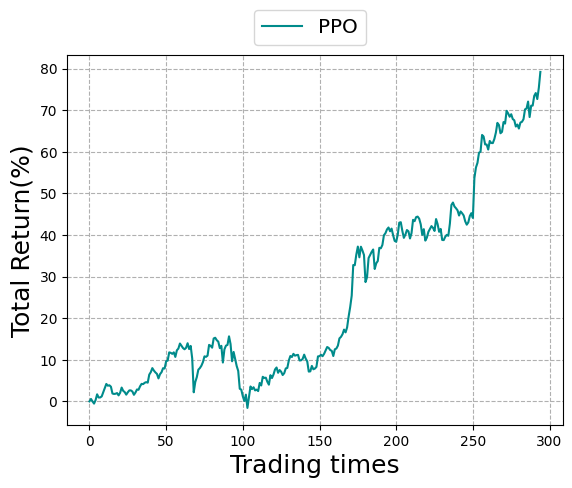

In [ ]:
plot(trainer.test_environment.save_asset_memory(),alg="PPO")